In [1]:
import simplegrad as sg
from pprint import pprint

In [2]:
VAL_SPLIT = 0.05

EPOCHS = 16
BATCH_SIZE = 32

LEARNING_RATE = 0.01
MOMENTUM = 0.8
DAMPENING = 0.1

In [3]:
# !curl -L -o ~/Downloads/mnist-dataset.zip https://www.kaggle.com/api/v1/datasets/download/hojjatk/mnist-dataset
# !mkdir -p ~/Developer/simplegrad/datasets/mnist/
# !unzip ~/Downloads/mnist-dataset.zip -d ~/Developer/simplegrad/datasets/mnist/

In [4]:
import numpy as np

In [5]:
np.random.seed(110)

In [6]:
def parse_mnist(folder_path):
    parse = lambda file_path, offset, dtype: np.frombuffer(
        open(file_path, "rb").read(), dtype=dtype, offset=offset
    )
    x = (
        parse(f"{folder_path}/train-images.idx3-ubyte", 16, np.uint8)
        .reshape(-1, 28, 28)
        .astype("float32")
        / 255.0
    )
    labels = parse(f"{folder_path}/train-labels.idx1-ubyte", 8, np.uint8)
    x_test = (
        parse(f"{folder_path}/t10k-images.idx3-ubyte", 16, np.uint8)
        .reshape(-1, 28, 28)
        .astype("float32")
        / 255.0
    )
    labels_test = parse(f"{folder_path}/t10k-labels.idx1-ubyte", 8, np.uint8)
    return (x, labels), (x_test, labels_test)


def to_one_hot(labels, num_classes=10):
    one_hot = np.zeros((len(labels), num_classes), dtype="float32")
    one_hot[np.arange(len(labels)), labels] = 1.0
    return one_hot


# After parsing MNIST data
(x, labels), (x_test, labels_test) = parse_mnist("./datasets/mnist")
x_train = x[: int(len(x) * (1 - VAL_SPLIT))]
y_train = labels[: int(len(labels) * (1 - VAL_SPLIT))]
x_val = x[int(len(x) * (1 - VAL_SPLIT)) :]
y_val = labels[int(len(labels) * (1 - VAL_SPLIT)) :]

# Convert labels to one-hot
y_train = to_one_hot(y_train)
y_val = to_one_hot(y_val)
y_test = labels_test

print("x train:", x_train.shape, x_train.dtype)
print("y train:", y_train.shape, y_train.dtype)
print("x val:", x_val.shape, x_val.dtype)
print("y val:", y_val.shape, y_val.dtype)
print("x test:", x_test.shape, x_test.dtype)
print("y test:", y_test.shape, y_test.dtype)

x train: (57000, 28, 28) float32
y train: (57000, 10) float32
x val: (3000, 28, 28) float32
y val: (3000, 10) float32
x test: (10000, 28, 28) float32
y test: (10000,) uint8


One-hot: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
Label: 8


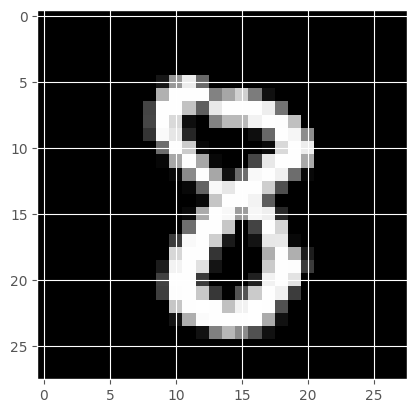

In [7]:
import matplotlib.pyplot as plt

idx = 55234
print("One-hot:", y_train[idx])
print("Label:", np.argmax(y_train[idx]))
plt.imshow(x_train[idx], cmap="gray");

In [8]:
model = sg.nn.Sequential(
    sg.nn.Linear(28 * 28, 64),
    sg.nn.ReLU(),
    sg.nn.Dropout(0.2),
    sg.nn.Linear(64, 64),
    sg.nn.ReLU(),
    sg.nn.Dropout(0.2),
    sg.nn.Linear(64, 10),
)

model.summary()

Parameters of Sequential

Parameter            Shape           Trainable Parameters                    
------------------------------------------------------------
modules.0.weight     (784, 64)       50176                                   
modules.0.bias       (1, 64)         64                                      
modules.3.weight     (64, 64)        4096                                    
modules.3.bias       (1, 64)         64                                      
modules.6.weight     (64, 10)        640                                     
modules.6.bias       (1, 10)         10                                      
------------------------------------------------------------
Total trainable parameters: 55050


In [9]:
optim = sg.optim.SGD(model, lr=LEARNING_RATE, momentum=MOMENTUM, dampening=DAMPENING)
loss_fn = sg.nn.CELoss(dim=1, reduction='mean')  # dim=1 for class dimension

In [10]:
tracker = sg.vis.TrainingTracker(title="MNIST Classification")
tracker.register_metric('train_loss', sg.vis.LineVisualizer(color='blue',marker=None))
tracker.register_metric('val_loss', sg.vis.LineVisualizer(color='red', linestyle='--', marker='s'))

In [11]:
for epoch in range(EPOCHS):
    for i in range(0, len(x_train), BATCH_SIZE):
        x_batch = sg.Tensor(x_train[i : i + BATCH_SIZE].reshape(-1, 28 * 28), dtype='float32')
        y_batch = sg.Tensor(y_train[i : i + BATCH_SIZE], dtype='float32')
        logits = model(x_batch)
        loss = loss_fn(logits, y_batch)
        tracker.log(train_loss=loss.values.item())
        optim.zero_grad()
        loss.backward()
        optim.step()

    # Validation
    x_val_tensor = sg.Tensor(x_val.reshape(-1, 28 * 28), dtype='float32', comp_grad=False)
    y_val_tensor = sg.Tensor(y_val, dtype='float32', comp_grad=False)
    val_logits = model(x_val_tensor)
    val_loss = loss_fn(val_logits, y_val_tensor)
    tracker.log(val_loss=val_loss.values.item())

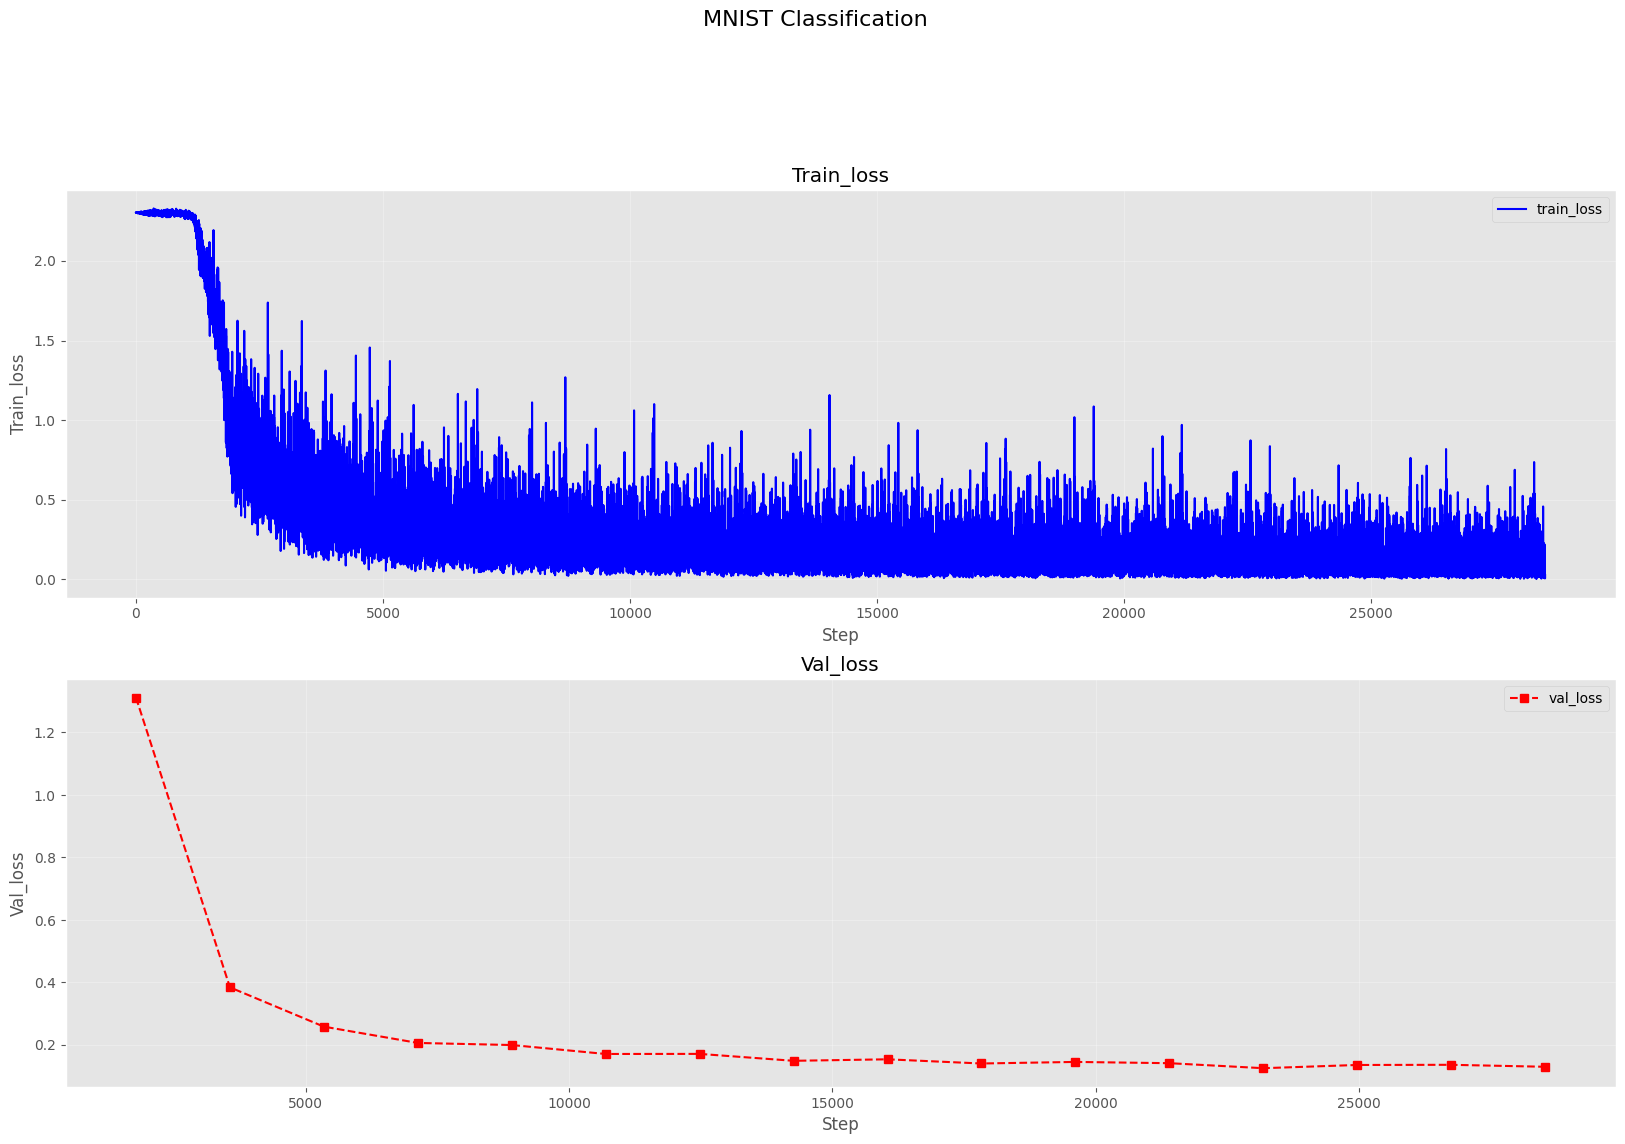

In [12]:
tracker.plot(num_cols=1, cell_w=20, cell_h=6);

In [48]:
x = sg.Tensor(x_test.reshape(-1, 28 * 28), dtype='float32', comp_grad=False)
predictions = sg.argmax(sg.softmax(model(x), dim=1), dim=1)
pred_labels = predictions.values.flatten()

correct = 0
for i in range(len(pred_labels)):
    if pred_labels[i] == y_test[i]:
        correct += 1

accuracy = correct / len(pred_labels)
print(f"Predictions: {correct}/{len(pred_labels)}")
print(f"Accuracy: {accuracy:.3%}")

Predictions: 9583/10000
Accuracy: 95.830%
